**Unsupervised learning applied to astronomy**

The purpose of this project is to demonstrate classification of stars by their stellar type using the https://www.kaggle.com/competitions/PLAsTiCC-2018/
dataset.<br>This data represents many stars and their measured brightness across multiple passbands (wavelengths). We'd like to classify a star based on its brigthness measurements.<br><br>Data is as described on the Kaggle page. We have measurements of brightness and passband information for objects (stars) based on their object IDs. We also have dates these measurements were made. Since stars generally have periodic brigthness curves, it is possible to compare these curves and do classification based on that. <br>However, since we do not know what the periods are for them, a simplification will be introduced - we will look at average, median, max, and min values for brightness across the several passbands we do have data for.<br><br>We therefore need to CLEAN this data first, and then TRANSFORM by calculating these values.<br>Another transformation is also to go from relative brightness (in Astronomy known as apparent magnitude) to absolute - we need to factor in the distances to stellar objects. This will make them comparable to each other.<br><br>Afterwards, we do unsupervised classification using KMeans clustering and compare to a supervised classif model.<br>

In [101]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [102]:
import pandas as pd
import numpy as np
# For EDA purposes, will be used later on once we have data as well

In [103]:
df_train = pd.read_csv("drive/MyDrive/AstroData/training_set.csv")
df_metadata = pd.read_csv("drive/MyDrive/AstroData/training_set_metadata.csv")

df_train.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [104]:
# We need to load in the metadata target column as well - this shows what the star type is

df_train = df_train.merge(
    df_metadata[["object_id", "target", "distmod"]],
    on="object_id",
    how="left"
)

In [105]:
df_train.head()

,object_id,mjd,passband,flux,flux_err,detected,target,distmod
0,615,59750.4229,2,-544.810303,3.622952,1,92,NaN
1,615,59750.4306,1,-816.434326,5.553370,1,92,NaN
2,615,59750.4383,3,-471.385529,3.801213,1,92,NaN
3,615,59750.4450,4,-388.984985,11.395031,1,92,NaN
4,615,59752.4070,2,-681.858887,4.041204,1,92,NaN


In [106]:
df_train = df_train.dropna()

print(df_train.info())
print(df_train.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1021131 entries, 352 to 1421308
Data columns (total 8 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   object_id  1021131 non-null  int64  
 1   mjd        1021131 non-null  float64
 2   passband   1021131 non-null  int64  
 3   flux       1021131 non-null  float64
 4   flux_err   1021131 non-null  float64
 5   detected   1021131 non-null  int64  
 6   target     1021131 non-null  int64  
 7   distmod    1021131 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 70.1 MB
None
     object_id         mjd  passband       flux  flux_err  detected  target  \
352        713  59825.2600         2   9.110147  1.013889         0      88   
353        713  59825.2676         1   7.615042  1.160329         1      88   
354        713  59825.2752         3   6.673631  1.932316         1      88   
355        713  59825.2862         4   5.214194  3.018003         0      88   
356        713  5982

**CLEANING: We just dropped NaN values. We also need to clean values with high errors. Let us remove any brightness (flux) measurements with relative error > 50%.**<br>Also, the dataset mentions there possibly being negative flux values, and that it corresponds to zero. Let us first set negative values to be zero.<br>

Let us explore the data a bit and look at how many times flux gets negative and how many times we have these large errors.

In [107]:
print(len(df_train[df_train["flux"] < 0]))
print(len(df_train[df_train["flux"] < df_train["flux_err"]*2]))

412977
830486


In [108]:
df_train["flux"].apply(lambda x: max(x, 0))
df_train = df_train[(df_train["flux"] == 0) | (df_train["flux"] >= df_train["flux_err"]*2)] # tolerate errors for zero flux
print(df_train.info())
print(df_train.head())

<class 'pandas.core.frame.DataFrame'>
Index: 190645 entries, 352 to 1421268
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   object_id  190645 non-null  int64  
 1   mjd        190645 non-null  float64
 2   passband   190645 non-null  int64  
 3   flux       190645 non-null  float64
 4   flux_err   190645 non-null  float64
 5   detected   190645 non-null  int64  
 6   target     190645 non-null  int64  
 7   distmod    190645 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 13.1 MB
None
     object_id         mjd  passband      flux  flux_err  detected  target  \
352        713  59825.2600         2  9.110147  1.013889         0      88   
353        713  59825.2676         1  7.615042  1.160329         1      88   
354        713  59825.2752         3  6.673631  1.932316         1      88   
357        713  59839.2161         2  4.953065  1.196956         0      88   
358        713  59839.2236         1

In [109]:
# Let us transform the data and take relevant flux stats per passband
flux_stats = df_train.groupby(["object_id", "passband"])["flux"].agg(
    flux_avg="mean",
    flux_median="median",
    flux_min="min",
    flux_max="max"
).reset_index()

metadata = df_train[["object_id", "target", "distmod"]].drop_duplicates("object_id")

df_train = flux_stats.merge(metadata, on="object_id", how="left")
df_train

,object_id,passband,flux_avg,flux_median,flux_min,flux_max,target,distmod
0,713,0,8.003621,7.267655,4.900619,14.509829,88,45.4063
1,713,1,5.236899,5.369752,1.648819,9.129021,88,45.4063
2,713,2,5.282361,4.982378,1.830853,10.529041,88,45.4063
3,713,3,5.923894,5.521505,2.552051,11.330316,88,45.4063
4,713,4,6.829914,6.783946,3.197614,9.827934,88,45.4063
...,...,...,...,...,...,...,...,...
28811,130755807,0,156.706806,156.706806,41.483131,271.930481,90,46.6108
28812,130755807,1,54.464066,54.464066,54.464066,54.464066,90,46.6108
28813,130755807,3,97.785987,22.524668,16.398903,329.695709,90,46.6108
28814,130755807,4,322.264394,343.739807,259.650909,363.402466,90,46.6108


**Absolute magnitude (brightness)**<br>
<br>
Note that we need the absolute flux and not the relative one. Flux can be measured in magnitudes, but given that we have values of 100+, it is likely to be in W/m^2 or W/m^2/Hz or something like that which scales linearly. It is impossible to measure magnitude 300 like in the last object (left as an exercise to understand why, hint: log scale).<br><br>Therefore, we apply the inverse square law to "reduce" distmod to 10 pc (distance in astronomy is measured in parsecs).<br>What we want to do is scale flux by distmod^2/100 to get the brightness as if we were at 10 pc. Given that this is just a convention we may simply divide by distmod^2 and understand we are dealing with flux at 1pc.

In [110]:
df_train["flux_avg"] *= df_train["distmod"]**2
df_train["flux_median"] *= df_train["distmod"]**2

df_train["flux_min"] *= df_train["distmod"]**2
df_train["flux_max"] *= df_train["distmod"]**2

df_train

,object_id,passband,flux_avg,flux_median,flux_min,flux_max,target,distmod
0,713,0,16501.322169,14983.957458,10103.763403,29915.379920,88,45.4063
1,713,1,10797.082666,11070.989958,3399.423026,18821.595452,88,45.4063
2,713,2,10890.813027,10272.328556,3774.728363,21708.061598,88,45.4063
3,713,3,12213.481380,11383.865018,5261.645416,23360.075970,88,45.4063
4,713,4,14081.452354,13986.680126,6592.623362,20262.566805,88,45.4063
...,...,...,...,...,...,...,...,...
28811,130755807,0,340455.984718,340455.984718,90124.868053,590787.101383,90,46.6108
28812,130755807,1,118326.814866,118326.814866,118326.814866,118326.814866,90,46.6108
28813,130755807,3,212446.577342,48936.344185,35627.710191,716285.910805,90,46.6108
28814,130755807,4,700140.883472,746797.650123,564108.912453,789516.087840,90,46.6108


**Getting data ready for training**

Let us do two things here:



1.   Since we have 6 passbands, we'd like every flux stat to be a separate dimension. This requires more cleaning - remove all object ids with fewer than 6 pass band data available, and create new columns.
2.   Do a test train split of the data. We do this to evaluate our model on the test part, and to make a parallel between a supervised learning approach using the exact same data.



In [111]:
valid_ids = (
    df_train.groupby("object_id")["passband"]
    .nunique()
    .loc[lambda x: x == 6] # we want 6 distinct values
    .index
)

df_train = df_train[df_train["object_id"].isin(valid_ids)]
df_train

,object_id,passband,flux_avg,flux_median,flux_min,flux_max,target,distmod
0,713,0,16501.322169,14983.957458,10103.763403,29915.379920,88,45.4063
1,713,1,10797.082666,11070.989958,3399.423026,18821.595452,88,45.4063
2,713,2,10890.813027,10272.328556,3774.728363,21708.061598,88,45.4063
3,713,3,12213.481380,11383.865018,5261.645416,23360.075970,88,45.4063
4,713,4,14081.452354,13986.680126,6592.623362,20262.566805,88,45.4063
...,...,...,...,...,...,...,...,...
28801,130695262,1,327392.985767,337540.878396,23023.308957,618930.908806,15,46.6624
28802,130695262,2,265957.247369,237137.910758,11700.373410,488121.016143,15,46.6624
28803,130695262,3,211919.184815,161386.516120,118817.759100,357750.381504,15,46.6624
28804,130695262,4,168829.102158,166169.547321,56205.134413,286772.179577,15,46.6624


**Final EDA step**

Let us plot the flux_avg values for one passband to make sure they make sense and that all stars have reasonable values compared to one another.

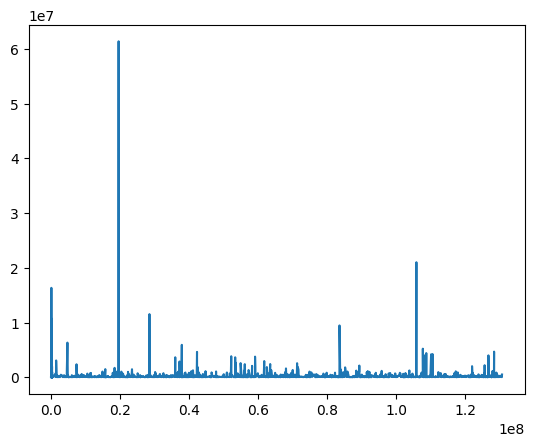

In [112]:
from matplotlib import pyplot as plt

df_train_pb = df_train[df_train["passband"]==0]
plt.plot(df_train_pb["object_id"], df_train_pb["flux_avg"])

In [113]:
# Creating new columns
fl_pivot = df_train[["object_id","passband","flux_avg","flux_min","flux_max","flux_median"]].pivot(index="object_id", columns="passband")
fl_pivot = fl_pivot.reset_index()
fl_pivot.columns = [f"passband_{pb}_{stat}" if stat != "object_id" else "object_id" for stat, pb in fl_pivot.columns]

df_train = fl_pivot.merge(df_train[["object_id", "target"]], on="object_id", how="left")
df_train

,object_id,passband_0_flux_avg,passband_1_flux_avg,passband_2_flux_avg,passband_3_flux_avg,passband_4_flux_avg,passband_5_flux_avg,passband_0_flux_min,passband_1_flux_min,passband_2_flux_min,...,passband_3_flux_max,passband_4_flux_max,passband_5_flux_max,passband_0_flux_median,passband_1_flux_median,passband_2_flux_median,passband_3_flux_median,passband_4_flux_median,passband_5_flux_median,target
0,713,16501.322169,10797.082666,10890.813027,12213.481380,14081.452354,30453.609512,10103.763403,3399.423026,3774.728363,...,23360.075970,20262.566805,30453.609512,14983.957458,11070.989958,10272.328556,11383.865018,13986.680126,30453.609512,88
1,713,16501.322169,10797.082666,10890.813027,12213.481380,14081.452354,30453.609512,10103.763403,3399.423026,3774.728363,...,23360.075970,20262.566805,30453.609512,14983.957458,11070.989958,10272.328556,11383.865018,13986.680126,30453.609512,88
2,713,16501.322169,10797.082666,10890.813027,12213.481380,14081.452354,30453.609512,10103.763403,3399.423026,3774.728363,...,23360.075970,20262.566805,30453.609512,14983.957458,11070.989958,10272.328556,11383.865018,13986.680126,30453.609512,88
3,713,16501.322169,10797.082666,10890.813027,12213.481380,14081.452354,30453.609512,10103.763403,3399.423026,3774.728363,...,23360.075970,20262.566805,30453.609512,14983.957458,11070.989958,10272.328556,11383.865018,13986.680126,30453.609512,88
4,713,16501.322169,10797.082666,10890.813027,12213.481380,14081.452354,30453.609512,10103.763403,3399.423026,3774.728363,...,23360.075970,20262.566805,30453.609512,14983.957458,11070.989958,10272.328556,11383.865018,13986.680126,30453.609512,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17005,130695262,515871.206038,327392.985767,265957.247369,211919.184815,168829.102158,271558.401185,233438.788906,23023.308957,11700.373410,...,357750.381504,286772.179577,318962.650646,563473.097876,337540.878396,237137.910758,161386.516120,166169.547321,262949.838727,15
17006,130695262,515871.206038,327392.985767,265957.247369,211919.184815,168829.102158,271558.401185,233438.788906,23023.308957,11700.373410,...,357750.381504,286772.179577,318962.650646,563473.097876,337540.878396,237137.910758,161386.516120,166169.547321,262949.838727,15
17007,130695262,515871.206038,327392.985767,265957.247369,211919.184815,168829.102158,271558.401185,233438.788906,23023.308957,11700.373410,...,357750.381504,286772.179577,318962.650646,563473.097876,337540.878396,237137.910758,161386.516120,166169.547321,262949.838727,15
17008,130695262,515871.206038,327392.985767,265957.247369,211919.184815,168829.102158,271558.401185,233438.788906,23023.308957,11700.373410,...,357750.381504,286772.179577,318962.650646,563473.097876,337540.878396,237137.910758,161386.516120,166169.547321,262949.838727,15


In [114]:
# Collapse object_ids
df_train = df_train.drop_duplicates(subset="object_id", keep="first")
print(df_train.info())
df_train

<class 'pandas.core.frame.DataFrame'>
Index: 2835 entries, 0 to 17004
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   object_id               2835 non-null   int64  
 1   passband_0_flux_avg     2835 non-null   float64
 2   passband_1_flux_avg     2835 non-null   float64
 3   passband_2_flux_avg     2835 non-null   float64
 4   passband_3_flux_avg     2835 non-null   float64
 5   passband_4_flux_avg     2835 non-null   float64
 6   passband_5_flux_avg     2835 non-null   float64
 7   passband_0_flux_min     2835 non-null   float64
 8   passband_1_flux_min     2835 non-null   float64
 9   passband_2_flux_min     2835 non-null   float64
 10  passband_3_flux_min     2835 non-null   float64
 11  passband_4_flux_min     2835 non-null   float64
 12  passband_5_flux_min     2835 non-null   float64
 13  passband_0_flux_max     2835 non-null   float64
 14  passband_1_flux_max     2835 non-null   floa

,object_id,passband_0_flux_avg,passband_1_flux_avg,passband_2_flux_avg,passband_3_flux_avg,passband_4_flux_avg,passband_5_flux_avg,passband_0_flux_min,passband_1_flux_min,passband_2_flux_min,...,passband_3_flux_max,passband_4_flux_max,passband_5_flux_max,passband_0_flux_median,passband_1_flux_median,passband_2_flux_median,passband_3_flux_median,passband_4_flux_median,passband_5_flux_median,target
0,713,16501.322169,1.079708e+04,1.089081e+04,1.221348e+04,1.408145e+04,3.045361e+04,10103.763403,3.399423e+03,3774.728363,...,2.336008e+04,2.026257e+04,3.045361e+04,14983.957458,1.107099e+04,1.027233e+04,1.138387e+04,13986.680126,3.045361e+04,88
6,730,9629.598427,3.761060e+03,1.555819e+04,2.157308e+04,2.942200e+04,4.574373e+04,9629.598427,3.761060e+03,3423.281706,...,5.440539e+04,6.670195e+04,7.666849e+04,9629.598427,3.761060e+03,1.022134e+04,1.424413e+04,15555.590978,4.514660e+04,42
12,745,19832.706379,3.412974e+04,5.099276e+04,7.431069e+04,7.709217e+04,6.604518e+04,6622.211401,3.119706e+03,2614.226759,...,3.382580e+05,3.056096e+05,2.355121e+05,21798.265361,8.884034e+03,2.193669e+04,4.453965e+04,42914.240510,4.125942e+04,90
18,1598,249646.482416,1.066913e+06,9.423527e+05,6.133875e+05,5.634915e+05,5.107748e+05,91200.801401,8.436491e+03,7131.138644,...,1.582606e+06,1.163858e+06,1.030704e+06,239249.975887,9.863491e+05,8.632497e+05,5.296647e+04,540652.078677,4.948423e+05,90
24,1920,28529.019423,1.042727e+05,1.468926e+05,1.263569e+05,1.369638e+05,1.207350e+05,6071.804133,1.007511e+04,6927.123119,...,3.818770e+05,3.188032e+05,2.540532e+05,35092.357448,2.666789e+04,6.536263e+04,6.880019e+04,105295.681468,1.169174e+05,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16980,130127657,122822.162203,7.899797e+04,9.735890e+04,7.800001e+04,1.176501e+05,1.189927e+05,62171.872495,1.927451e+04,19871.807519,...,1.313428e+05,2.306835e+05,1.799203e+05,124522.110299,6.273492e+04,9.313030e+04,8.295453e+04,95409.147768,1.026765e+05,88
16986,130414189,260573.696708,2.083958e+06,2.970391e+06,2.203108e+06,1.596883e+06,2.802554e+06,249636.001829,2.083958e+06,816337.894637,...,3.962771e+06,3.844814e+06,4.505202e+06,260573.696708,2.083958e+06,2.548677e+06,2.418285e+06,873504.389360,3.823300e+06,90
16992,130595291,426634.148847,1.954377e+05,2.650517e+05,2.676476e+05,8.933256e+04,1.799070e+05,43107.044267,1.391445e+04,12054.221690,...,3.853612e+05,1.079112e+05,2.404681e+05,414261.819388,1.603513e+05,2.998106e+05,3.167032e+05,101671.437852,2.200212e+05,15
16998,130617044,33278.156273,3.040038e+04,7.447356e+04,1.048125e+05,7.682580e+04,4.636599e+05,33278.156273,1.588080e+04,10544.292298,...,2.324700e+05,2.519542e+05,6.274871e+05,33278.156273,1.861204e+04,4.804061e+04,7.108839e+04,51487.240386,5.821102e+05,52


In [115]:
df_train = df_train.reset_index()
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_train, test_size=0.2)

print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2268 entries, 1770 to 746
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   index                   2268 non-null   int64  
 1   object_id               2268 non-null   int64  
 2   passband_0_flux_avg     2268 non-null   float64
 3   passband_1_flux_avg     2268 non-null   float64
 4   passband_2_flux_avg     2268 non-null   float64
 5   passband_3_flux_avg     2268 non-null   float64
 6   passband_4_flux_avg     2268 non-null   float64
 7   passband_5_flux_avg     2268 non-null   float64
 8   passband_0_flux_min     2268 non-null   float64
 9   passband_1_flux_min     2268 non-null   float64
 10  passband_2_flux_min     2268 non-null   float64
 11  passband_3_flux_min     2268 non-null   float64
 12  passband_4_flux_min     2268 non-null   float64
 13  passband_5_flux_min     2268 non-null   float64
 14  passband_0_flux_max     2268 non-null   flo

**Correlation heatmap**

Now that we have our features well extracted, let's take a look at their correlations.


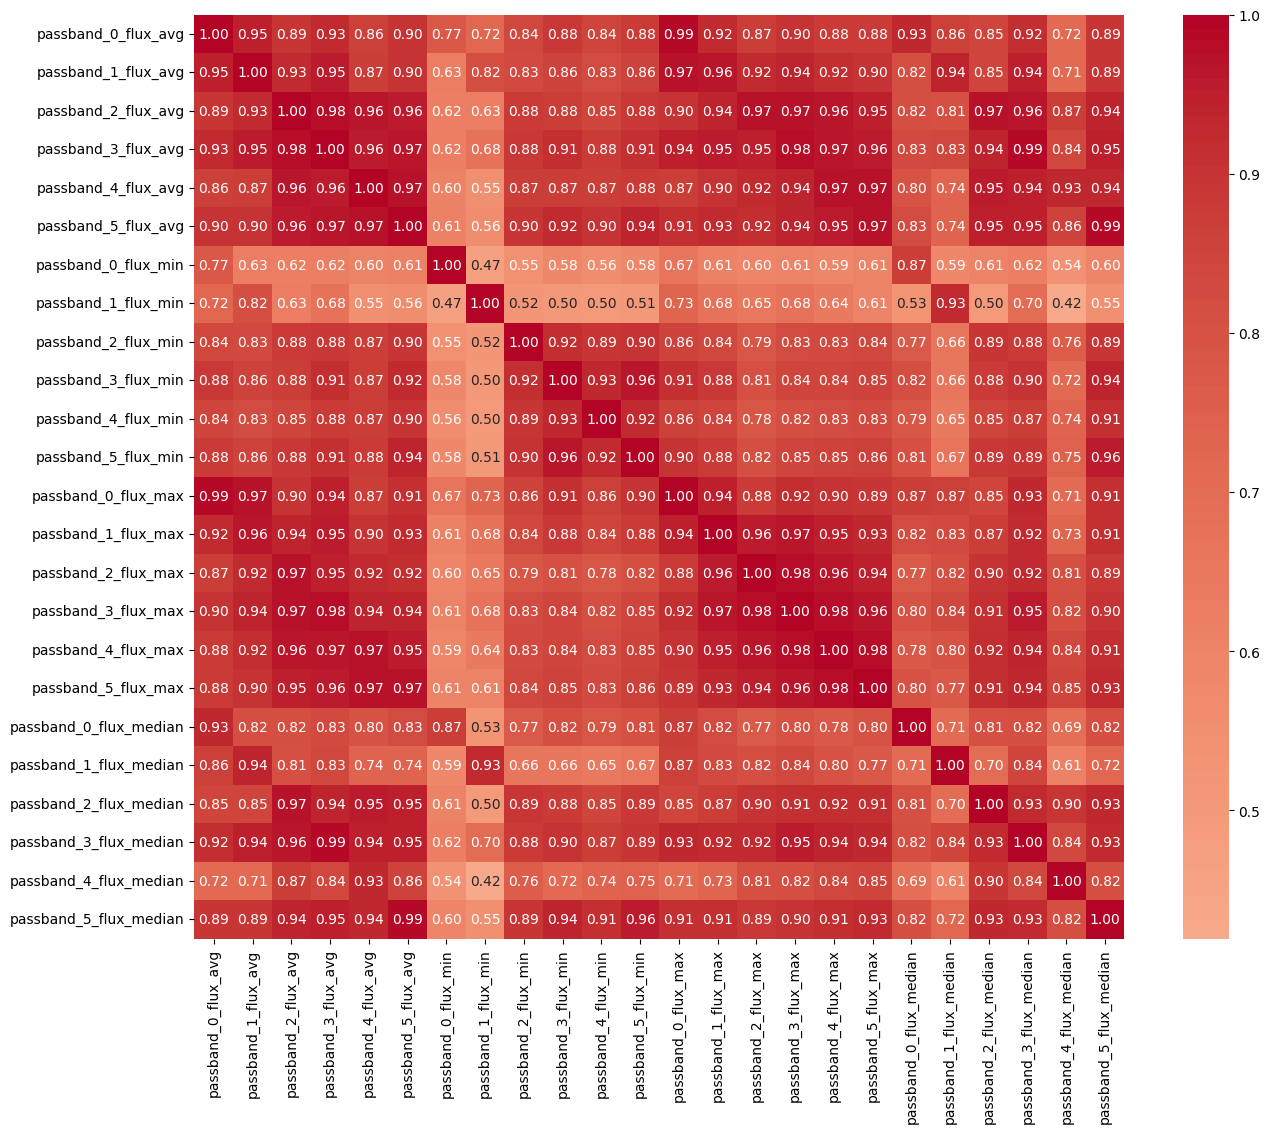

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

df_corr = df_train.drop(columns=["object_id", "target", "index"])

corr_matrix = df_corr.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.show()

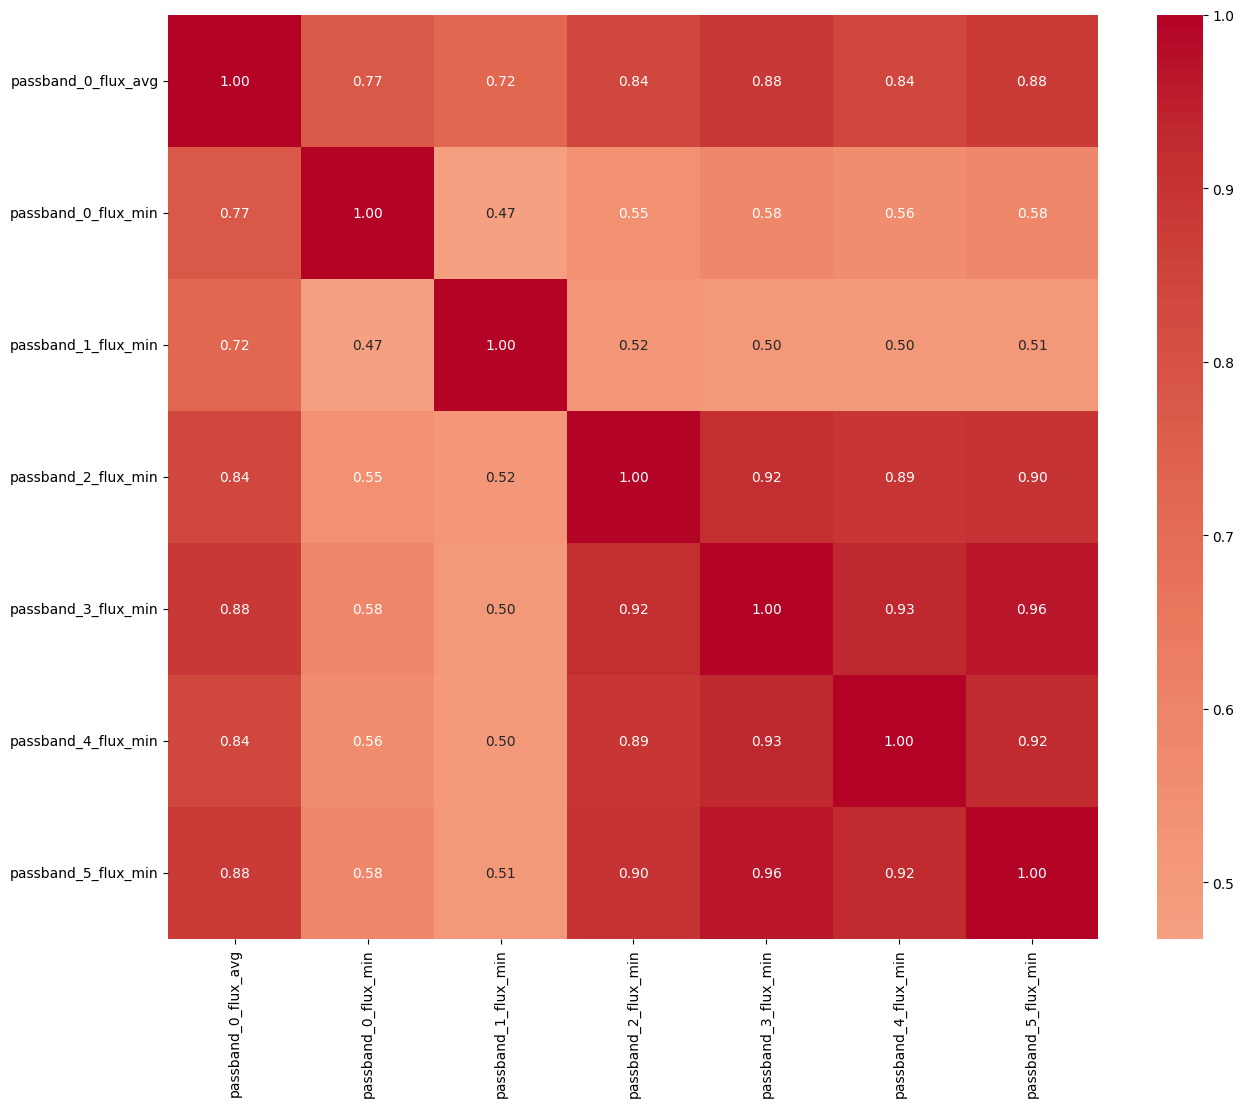

In [117]:
# Since it appears the minimums are not highly correlated with one another, and the avg,max and median all are, we leave passband0_avg and all minima
df_train = df_train.drop([f"passband_{i}_flux_{key}" for i in range(6) for key in {"max", "median"}] + [f"passband_{i}_flux_avg" for i in range(1,6)],axis=1)
df_corr = df_train.drop(columns=["object_id", "target", "index"])

corr_matrix = df_corr.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.show()

From what we see


1.   avg is highly correlated (>0.7) with 0..4_min
2.   0_min is highly correlated only to avg - candidate for keeping
3. 1_min is highly correlated to avg, 2 and 4 min
4. 2_min is highly correlated to avg, 1 and 4 min
5. 3_min is almost 1 correlated to 5_min and very correlated to avg
6. 4_min is hihgly correlated to 1 and 2
7. 5_min is almost 1 correlated to 3_min

Conclusion: We may keep 0_min, 1_min to represent 2 and 4, and 3_min to represent 5 and 3.

Let us also visualise this as a 3D plot.




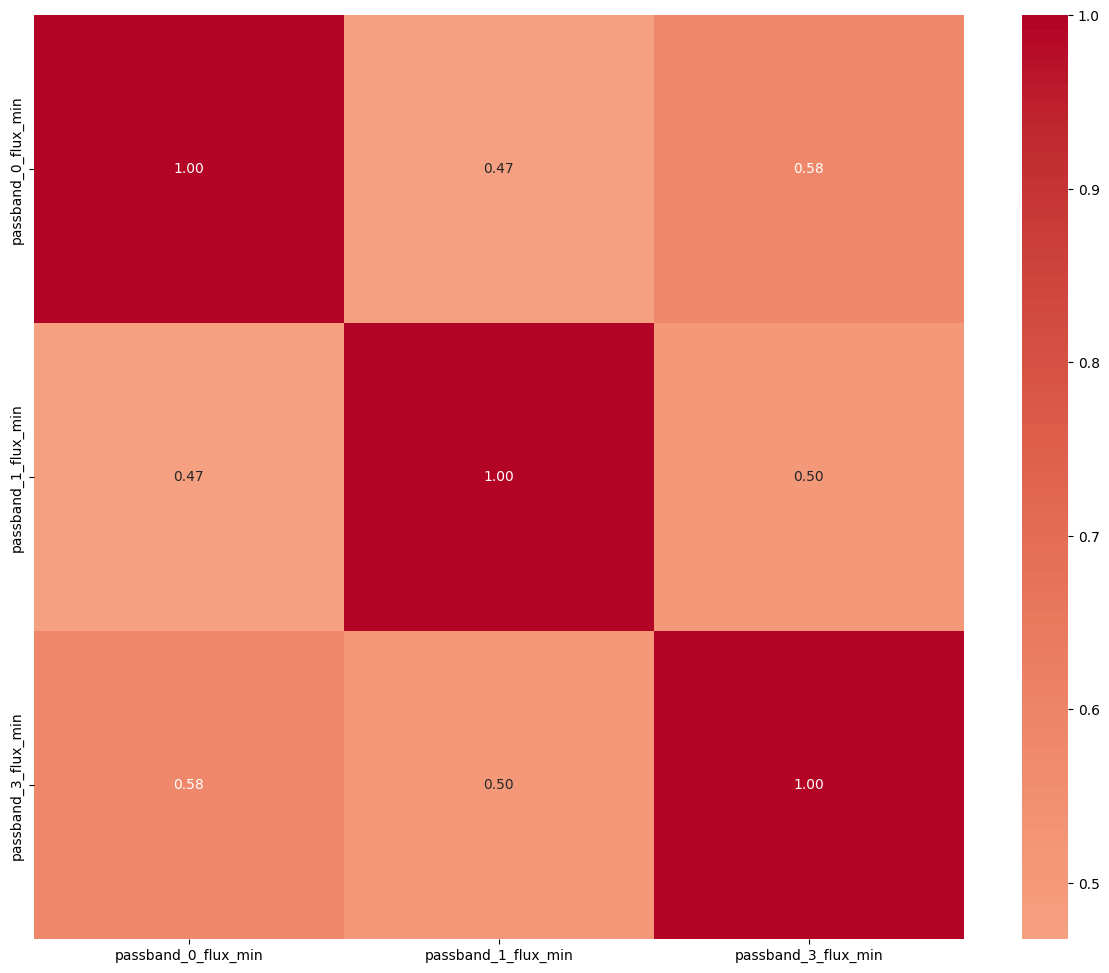

In [118]:
df_train = df_train.drop(["passband_0_flux_avg"] + [f"passband_{i}_flux_min" for i in {2,4,5}], axis=1)

df_corr = df_train.drop(columns=["object_id", "target", "index"])

corr_matrix = df_corr.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.show()

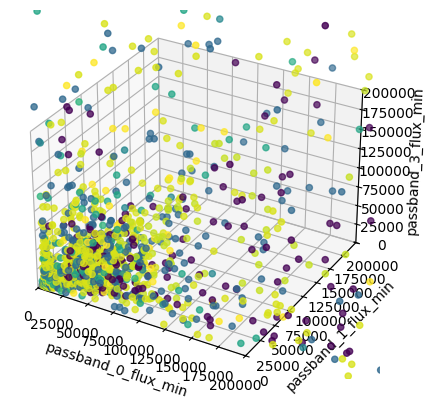

In [119]:
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting (sometimes optional in newer versions)

# Suppose you have three arrays:
x = df_train["passband_0_flux_min"]
y = df_train["passband_1_flux_min"]
z = df_train["passband_3_flux_min"]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")  # Create a 3D axes

ax.scatter(x, y, z, c=df_train["target"])

ax.set_xlabel("passband_0_flux_min")
ax.set_ylabel("passband_1_flux_min")
ax.set_zlabel("passband_3_flux_min")

ax.set_xlim(0, 0.2e6)
ax.set_ylim(0, 0.2e6)
ax.set_zlim(0, 0.2e6
          )

plt.show()

**Unsupervised model - KMeans and KNN clustering**

Now that we have split the test and train data, let us try out KMeans clustering to get the right target. <br>Note we would usually need to normalize data to make sure every dimension has the same range and scale. However, all our dimensions are fluxes and they all refer to the same physical value, so no need to do this. We *sort of already did this when we got absolute flux* so all good!<br>We will do **hyperparameter tuning** by iterating through various numbers for the parameter K in KNN, going from 3 to 50.

In [120]:
print(df_train["target"].unique())

[88 62 90 67 15 95 42 52 64]


In [121]:
# KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy.stats import mode

features = [col for col in df_train.columns if col not in ["object_id", "target"]]
X_train = df_train[features]
X_test = df_test[features]
y_test = df_test["target"]

n_clusters = 9 # We know this to be the number of star types in the data
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X_train)


train_clusters = kmeans.predict(X_train)
labels = df_train["target"].unique()

from itertools import permutations
import copy
from concurrent.futures import ProcessPoolExecutor


# Map clusters to labels - try out all permutations

def evaluate_perm(perm):
    cluster_to_label = {i: perm[i] for i in range(len(labels))}
    y_pred = [cluster_to_label[c] for c in train_clusters]
    acc_t = accuracy_score(df_train["target"], y_pred)
    return acc_t, cluster_to_label

# Run permutations in parallel
best_acc = 0
best_cl_to_label = None

executor = ProcessPoolExecutor()
results = executor.map(evaluate_perm, permutations(labels))

In [122]:
# Check all permutations

i = 0
for acc_t, cluster_to_label in results:
  print(i)
  i += 1
  if acc_t > best_acc:
      best_acc = acc_t
      best_cl_to_label = cluster_to_label

# Predict on test set
test_clusters = kmeans.predict(X_test)
y_pred = [best_cl_to_label[c] for c in test_clusters]
acc_kmeans = accuracy_score(df_test["target"], y_pred)

print(f"KMeans Classification Accuracy: {acc_kmeans:.4f}")

Streaming output truncated to the last 5000 lines.
357881
357882
357883
357884
357885
357886
357887
357888
357889
357890
357891
357892
357893
357894
357895
357896
357897
357898
357899
357900
357901
357902
357903
357904
357905
357906
357907
357908
357909
357910
357911
357912
357913
357914
357915
357916
357917
357918
357919
357920
357921
357922
357923
357924
357925
357926
357927
357928
357929
357930
357931
357932
357933
357934
357935
357936
357937
357938
357939
357940
357941
357942
357943
357944
357945
357946
357947
357948
357949
357950
357951
357952
357953
357954
357955
357956
357957
357958
357959
357960
357961
357962
357963
357964
357965
357966
357967
357968
357969
357970
357971
357972
357973
357974
357975
357976
357977
357978
357979
357980
357981
357982
357983
357984
357985
357986
357987
357988
357989
357990
357991
357992
357993
357994
357995
357996
357997
357998
357999
358000
358001
358002
358003
358004
358005
358006
358007
358008
358009
358010
358011
358012
358013
358014
358015
3580

Let us also try using GMM, an unsupervised probabilistic approach.<br>KMeans may be less suited as it assumes spherical clusters, and as we have seen from the data above, that may not result in a good clustering approximation.

In [129]:
# AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from scipy.stats import mode

features = [col for col in df_train.columns if col not in ["object_id", "target"]]
X_train = df_train[features]
X_test = df_test[features]
y_test = df_test["target"]

n_clusters = 9 # We know this to be the number of star types in the data
gmm = GaussianMixture(n_components=n_clusters)
gmm.fit(X_train)


train_clusters = gmm.predict(X_train)
labels = df_train["target"].unique()

from itertools import permutations
import copy
from concurrent.futures import ProcessPoolExecutor


# Map clusters to labels - try out all permutations

def evaluate_perm(perm):
    cluster_to_label = {i: perm[i] for i in range(len(labels))}
    y_pred = [cluster_to_label[c] for c in train_clusters]
    acc_t = accuracy_score(df_train["target"], y_pred)
    return acc_t, cluster_to_label

# Run permutations in parallel
best_acc = 0
best_cl_to_label = None

executor = ProcessPoolExecutor()
results = executor.map(evaluate_perm, permutations(labels))

In [130]:
# Check all permutations

i = 0
for acc_t, cluster_to_label in results:
  print(i)
  i += 1
  if acc_t > best_acc:
      best_acc = acc_t
      best_cl_to_label = cluster_to_label

# Predict on test set
test_clusters = gmm.predict(X_test)
y_pred = [best_cl_to_label[c] for c in test_clusters]
acc_gmm = accuracy_score(df_test["target"], y_pred)

print(f"GMM Classification Accuracy: {acc_gmm:.4f}")

Streaming output truncated to the last 5000 lines.
357881
357882
357883
357884
357885
357886
357887
357888
357889
357890
357891
357892
357893
357894
357895
357896
357897
357898
357899
357900
357901
357902
357903
357904
357905
357906
357907
357908
357909
357910
357911
357912
357913
357914
357915
357916
357917
357918
357919
357920
357921
357922
357923
357924
357925
357926
357927
357928
357929
357930
357931
357932
357933
357934
357935
357936
357937
357938
357939
357940
357941
357942
357943
357944
357945
357946
357947
357948
357949
357950
357951
357952
357953
357954
357955
357956
357957
357958
357959
357960
357961
357962
357963
357964
357965
357966
357967
357968
357969
357970
357971
357972
357973
357974
357975
357976
357977
357978
357979
357980
357981
357982
357983
357984
357985
357986
357987
357988
357989
357990
357991
357992
357993
357994
357995
357996
357997
357998
357999
358000
358001
358002
358003
358004
358005
358006
358007
358008
358009
358010
358011
358012
358013
358014
358015
3580

In [131]:
from sklearn.neighbors import KNeighborsClassifier
# Do a KNN classifier with hyperparameter tuning
X_train = df_train[features]
y_train = df_train['target']
X_test = df_test[features]
y_test = df_test['target']

best_k = None
best_acc = 0
best_model = None

k_vals = []
acc_vals = []
for k in range(3, 51):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    k_vals.append(k)
    acc_vals.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_k = k
        best_model = model

print(f"Best KNN (k={best_k}) Accuracy: {best_acc:.4f}")

Best KNN (k=33) Accuracy: 0.4674


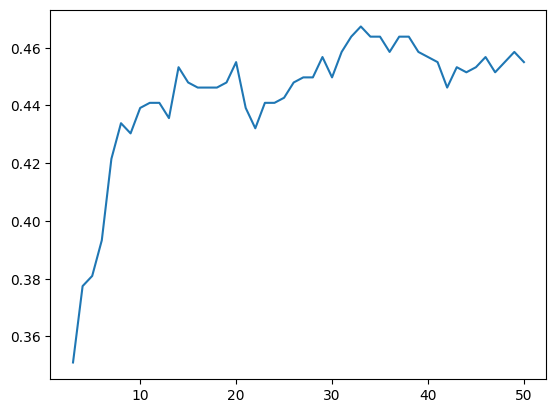

In [132]:
plt.plot(k_vals, acc_vals) # Plot k moving from 3 to 50 and metrics

In [133]:
print("Model Accuracy Comparison:")
print(f"- KMeans Clustering Accuracy       : {acc_kmeans:.4f}")
print(f"- KNN Classifier (k={best_k}) Acc  : {best_acc:.4f}")
print(f"- GMM Classifier Accuracy          : {acc_gmm:.4f}")

Model Accuracy Comparison:
- KMeans Clustering Accuracy       : 0.4374
- KNN Classifier (k=33) Acc  : 0.4674
- GMM Classifier Accuracy          : 0.2822


Using this dataset, it appears we can get somewhat acceptable accuracies of 44-47% when using the Kmeans and Knn methods. The GMM method gives a much worse number of ~30%.
<br>Note that although the unsupervised approach seems to yield bad accuracy of 40% - a random model is expected to give around 11% (guessing 1/9 classes), thus an accuracy of 40% is a visible improvement.

Let us, for the end, try out a linear classifier.

In [135]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

X_train = df_train[features]
y_train = df_train['target']
X_test = df_test[features]
y_test = df_test['target']

# Encode target - since we have random numbers we will do this
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Train linear classifier
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=0)
model.fit(X_train, y_train_enc)

# Predict on test set
y_pred = model.predict(X_test)

acc = accuracy_score(y_test_enc, y_pred)
print(f"Test Accuracy: {acc:.4f}\n")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Accuracy: 0.4162



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


It appears this simple model is still outperformed by KMeans and Knn, meaning there is some sense in using the unsupervised KMeans approach vs this one.